In [110]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join as oj
import math
import load_data

outcomes = [load_data.outcome_cases, load_data.outcome_deaths]
df_hospital = load_data.load_hospital_level()
df_county = load_data.load_county_level()
df_county = df_county.sort_values(load_data.outcome_deaths, ascending=False)
df = df_hospital.merge(df_county, how='left', on='countyFIPS')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
# note this many hospitals couldn't be matched to a county - we don't know how to include them!
print('# unmatched hospitals:', df['countyFIPS'].isna().sum())
print('# matched hospitals:', (~df['countyFIPS'].isna()).sum())
print('# academic matched hospitals:', (~df['countyFIPS'].isna() & df['IsAcademicHospital']).sum())
print('# academic matched hospitals w/ ICU beds:', (~df['countyFIPS'].isna() & 
                                                    df['IsAcademicHospital'] &
                                                    df['ICU Beds'] > 0).sum())
df = df[~df['countyFIPS'].isna() & df['IsAcademicHospital'] & df['ICU Beds'] > 0]
df = df.sort_values(by=[load_data.outcome_deaths, 'ICU Beds'], ascending=False)

# unmatched hospitals: 0
# matched hospitals: 1087
# academic matched hospitals: 1087
# academic matched hospitals w/ ICU beds: 1087


# look at important hospitals

In [140]:
hospital_keys = ['County Name_x', 'Facility Name_x', 'City_x',
                 'ICU Beds', 'Total Beds', 'Total Employees', 
                 'Hospital Type', 'Mortality national comparison',  
                 'Website', 'Urban or Rural Designation', 'Phone Number'] + ['countyFIPS']
d = df[outcomes + hospital_keys]
d[outcomes] = d[outcomes].fillna(0)
d.head(30)

,#Cases_3/23/2020,#Deaths_3/23/2020,County Name_x,Facility Name_x,City_x,ICU Beds,Total Beds,Total Employees,Hospital Type,Mortality national comparison,Website,Urban or Rural Designation,Phone Number,countyFIPS
3757,12305.0,125.0,"New York County, NY",New York Presbyterian/Weill Cornell Medical Ce...,New York,290.0,2650.0,26491.0,Acute Care Hospitals,Above the national average,NOT AVAILABLE,Rural,(212) 746-5454,36061.0
3820,12305.0,125.0,"New York County, NY",NYU Langone Tisch Hospital,New York,228.0,1629.0,16151.0,Acute Care Hospitals,Above the national average,http://nyulangone.org/locations/tisch-hospital,Urban,(212) 263-7300,36061.0
3720,12305.0,125.0,"New York County, NY",The Mount Sinai Hospital,New York,75.0,1161.0,11256.0,Acute Care Hospitals,Above the national average,http://www.nyc.gov/html/hhc/mhc/html/home/home...,Urban,(212) 241-7981,36061.0
3729,12305.0,125.0,"New York County, NY",Mount Sinai Morningside,New York,57.0,783.0,5706.0,Acute Care Hospitals,Above the national average,http://www.stlukeshospitalnyc.org/index.aspx,Rural,(212) 523-4000,36061.0
3815,12305.0,125.0,"New York County, NY",NYC Health + Hospitals Bellevue,New York,45.0,912.0,4179.0,Acute Care Hospitals,Same as the national average,http://www.nychealthandhospitals.org/bellevue/...,Urban,(212) 562-4141,36061.0
3794,12305.0,125.0,"New York County, NY",Mount Sinai Beth Israel Medical Center,New York,28.0,554.0,4672.0,Acute Care Hospitals,Above the national average,http://www.bethisraelny.org/,Rural,(212) 420-2000,36061.0
3783,12305.0,125.0,"New York County, NY",Memorial Sloan-Kettering Cancer Center,New York,25.0,498.0,13856.0,NaN,NaN,NOT AVAILABLE,Urban,NaN,36061.0
3767,12305.0,125.0,"New York County, NY",Lenox Hill Hospital,New York,24.0,449.0,5287.0,Acute Care Hospitals,Above the national average,NOT AVAILABLE,Rural,(212) 439-2345,36061.0
3811,12305.0,125.0,"New York County, NY",NYC Health + Hospitals Metropolitan,New York,24.0,338.0,1596.0,Acute Care Hospitals,Not Available,http://www.nyc.gov/html/hhc/mhc/html/home/home...,Urban,(212) 423-6262,36061.0
3738,12305.0,125.0,"New York County, NY","NewYork-Presbyterian, Lower Manhattan Hospital",New York,20.0,132.0,1121.0,NaN,NaN,http://www.nyp.org/lowermanhattan,Urban,NaN,36061.0


# useful county-level plots

/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


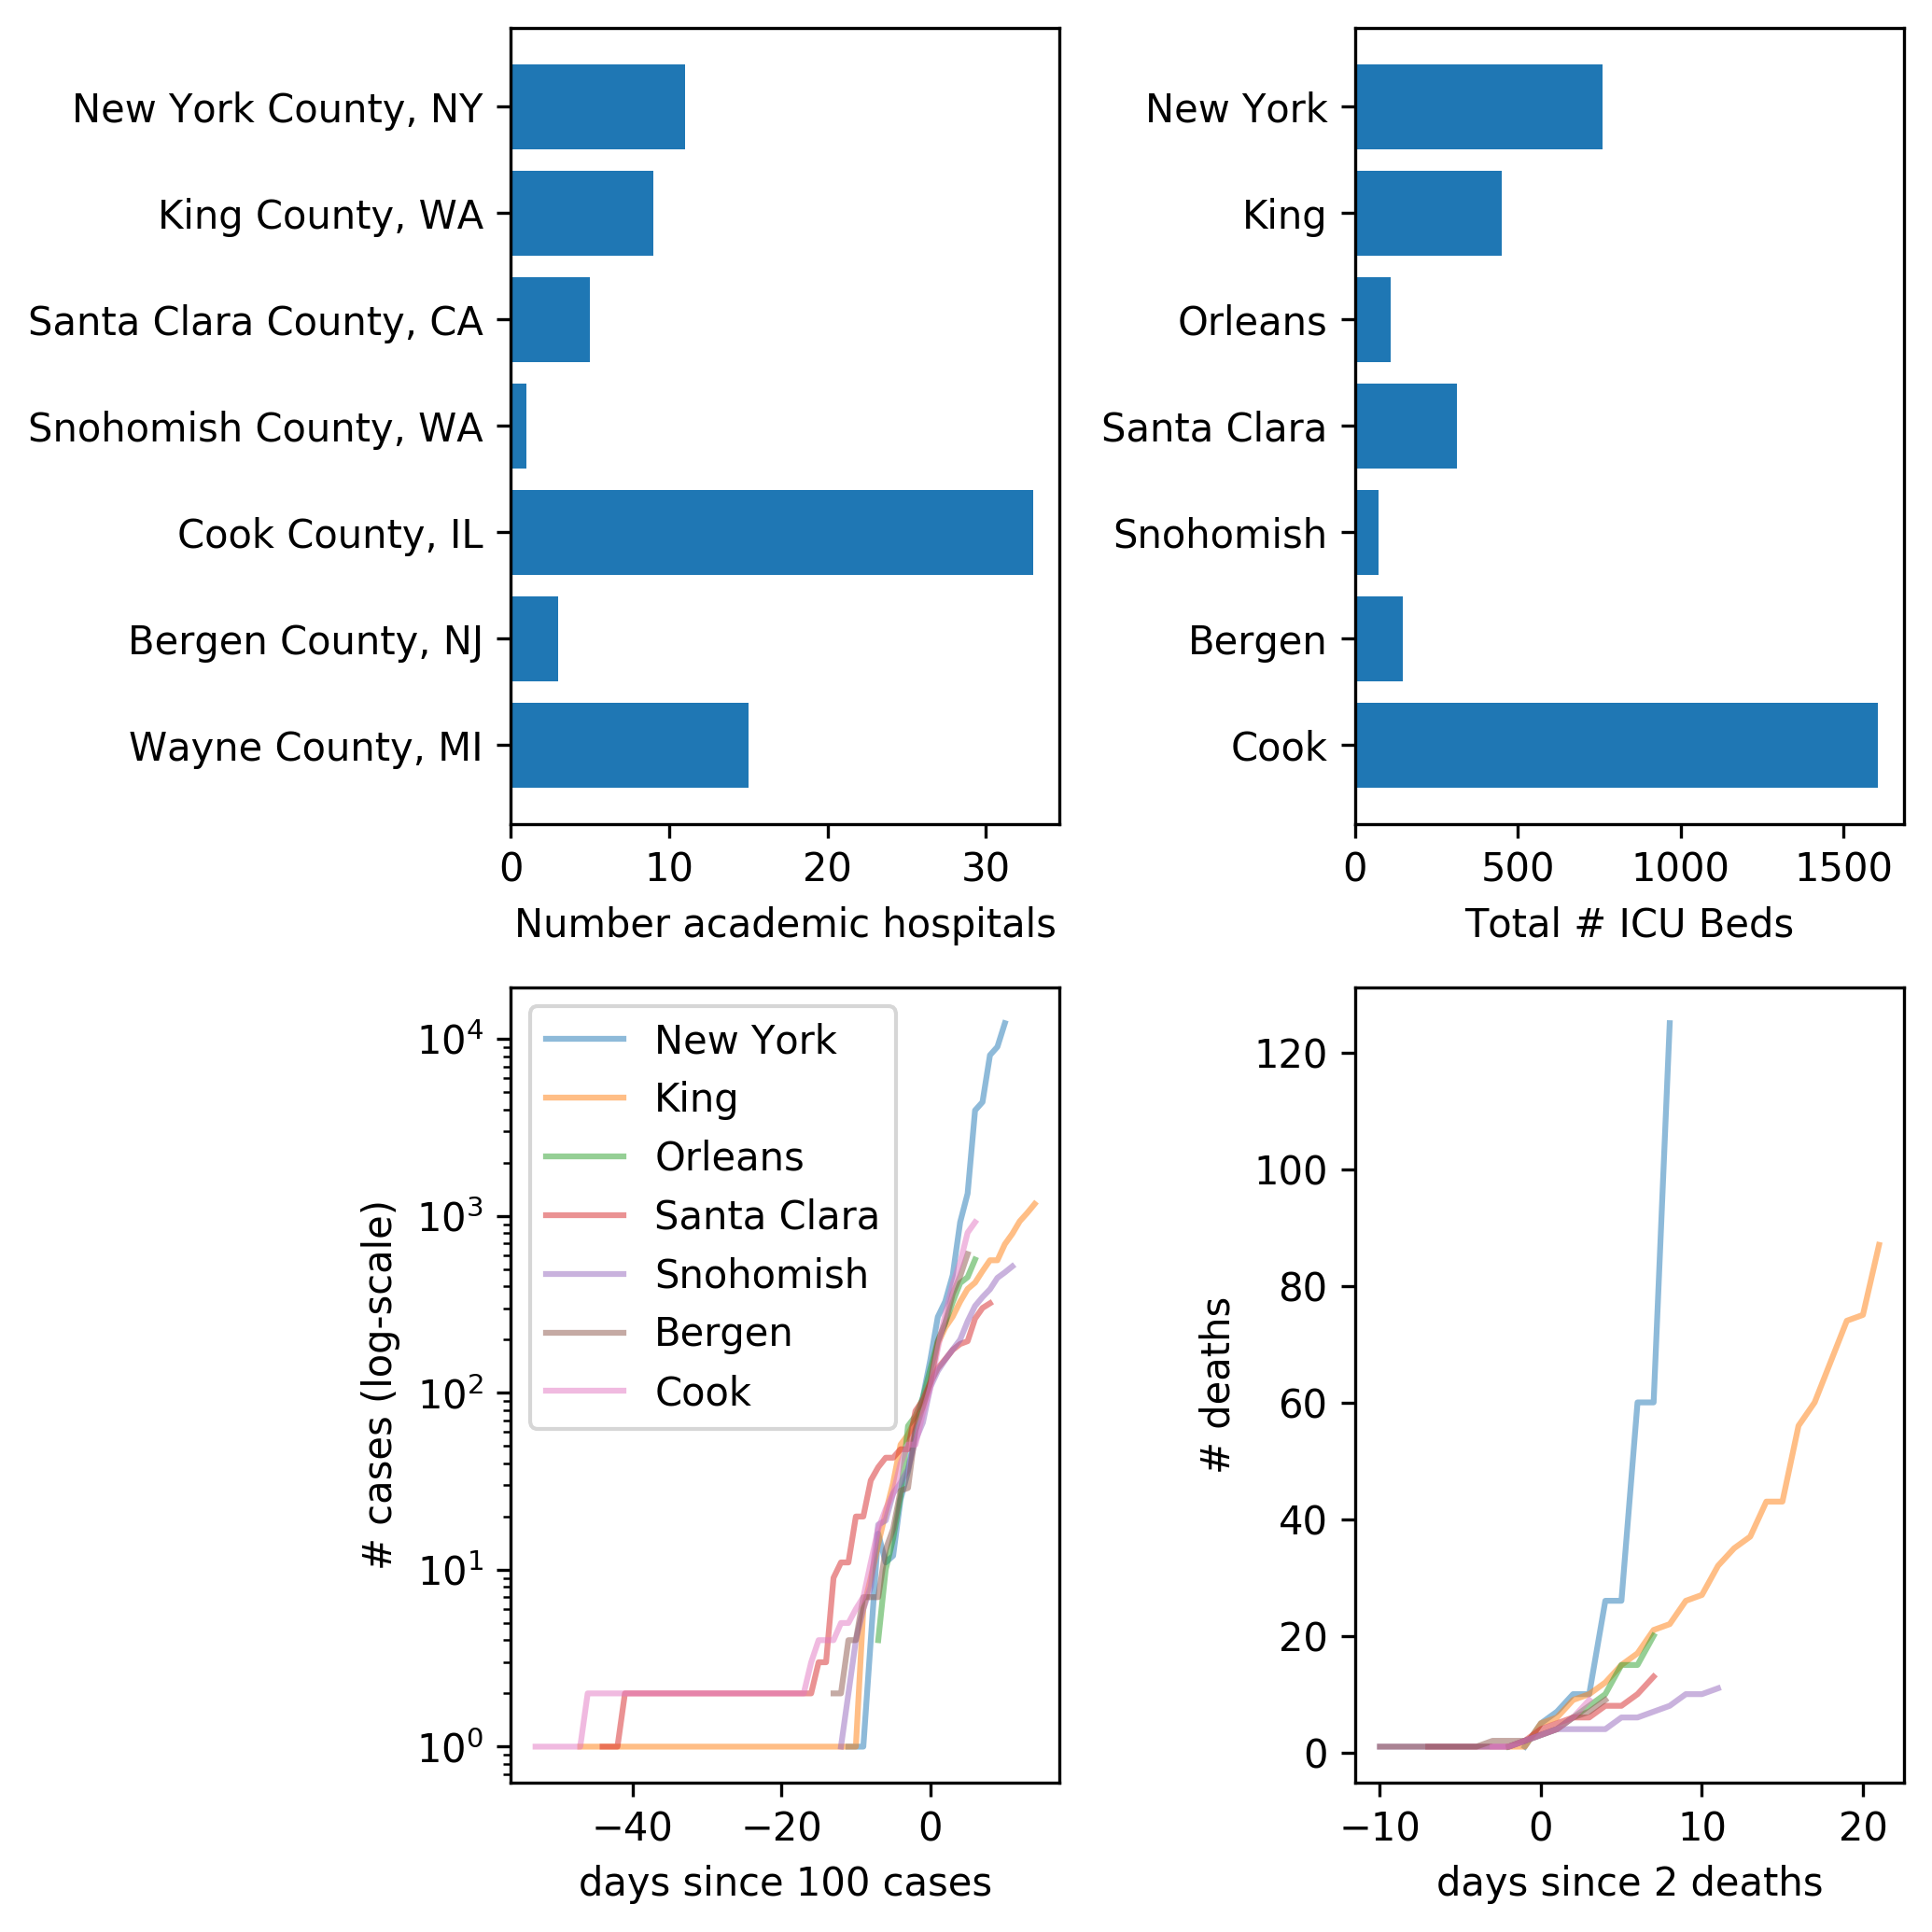

In [148]:
R, C = 2, 2
NUM_COUNTIES = 7
plt.figure(dpi=300, figsize=(7, 7))


plt.subplot(R, C, 1)
c = 'County Name_x'
county_names = d[c].unique()[:NUM_COUNTIES]
num_academic_hospitals = []
d = df[outcomes + hospital_keys]
d = d.sort_values(load_data.outcome_deaths, ascending=False)
for county in county_names:
    num_academic_hospitals.append(d[d[c] == county].shape[0])
plt.barh(county_names[::-1], num_academic_hospitals[::-1]) # reverse to plot top down
plt.xlabel('Number academic hospitals')

plt.subplot(R, C, 2)
plt.barh(df_county.CountyName[:NUM_COUNTIES].values[::-1], df_county['#ICU_beds'][:NUM_COUNTIES][::-1]) # reverse to plot top down
plt.xlabel('Total # ICU Beds')

r = df_county
for i in range(NUM_COUNTIES):
    row = df_county.iloc[i]
    deaths = np.array([x for x in row['deaths'] if x > 0])
    cases = np.array([x for x in row['cases'] if x > 0])
    
    CASES_ALIGNMENT = 100
    idx_align = np.where(cases > CASES_ALIGNMENT)[0][0]
    n = cases.size
    
    DEATHS_ALIGNMENT = 2
    idx_align_deaths = np.where(deaths > DEATHS_ALIGNMENT)[0][0]
    n2 = deaths.size

    
    plt.subplot(R, C, 3)
    plt.plot(np.arange(n) - idx_align, cases, alpha=0.5, label=row['CountyName'])
    plt.yscale('log')
    plt.ylabel('# cases (log-scale)')
    plt.xlabel(f'days since {CASES_ALIGNMENT} cases')
    plt.legend()
    
    plt.subplot(R, C, 4)
    plt.plot(np.arange(n2) - idx_align_deaths, deaths, alpha=0.5)
    plt.ylabel('# deaths')
    plt.xlabel(f'days since {DEATHS_ALIGNMENT} deaths')
plt.tight_layout()
plt.show()

In [ ]:
load_data.important_keys(df_county)